# 音声セグメントからMUSIC法により基本周波数を推定

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
import librosa

In [3]:
IN_WAVE_FILE = "voice_a.wav"    # 「あ」の音声

FRAME_LENGTH = 1024             # フレーム長 (FFTサイズ)
HOP_LENGTH = 80                 # フレームのシフト長
CUTOFF = 4000                   # 遮断周波数 (Hz)

In [4]:
# 音声のロード
fs, data = wavfile.read(IN_WAVE_FILE)
data = data.astype(np.float64)

In [5]:
# フレーム化
frames = librosa.util.frame(data, frame_length=FRAME_LENGTH,
                            hop_length=HOP_LENGTH).T

In [6]:
# 周波数軸
freq_axis = np.linspace(0, fs, frames.shape[0])

In [7]:
# MUSIC法のノイズ成分を高域の周波数成分と見なす
ORDER = np.min(np.where(freq_axis > CUTOFF))

# 標本共分散行列の計算
cov_frames = np.cov(frames, bias=True)

# 固有値と固有ベクトルを計算
# →固有値は大きい順に並び、固有ベクトル（縦）もそれに対応して並ぶ
eigval, eigvec = np.linalg.eig(cov_frames)

# ノイズ成分の固有ベクトル
noise_eigvec = eigvec[:, 2 * ORDER + 1:]

# パワースペクトルをノイズ成分の固有ベクトルから計算
power_noise_eigvec = np.abs(np.fft.fft(noise_eigvec))
power_noise_eigvec = power_noise_eigvec ** 2

# MUSIC法の疑似スペクトルを計算
music_pseudo_spec = 1.0 / np.sum(power_noise_eigvec, axis=1)

# 基本周波数の推定
# →ピーク位置の最小値を与える周波数
fo = freq_axis[np.min(scipy.signal.argrelmax(music_pseudo_spec))]
print(f"Estimatied fundamental frequency = {fo:.2f} Hz")

Estimatied fundamental frequency = 108.22 Hz


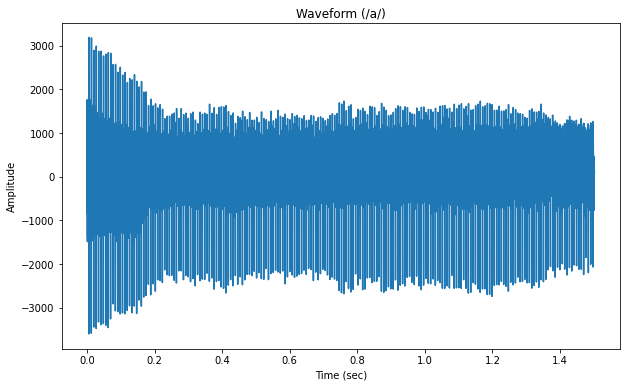

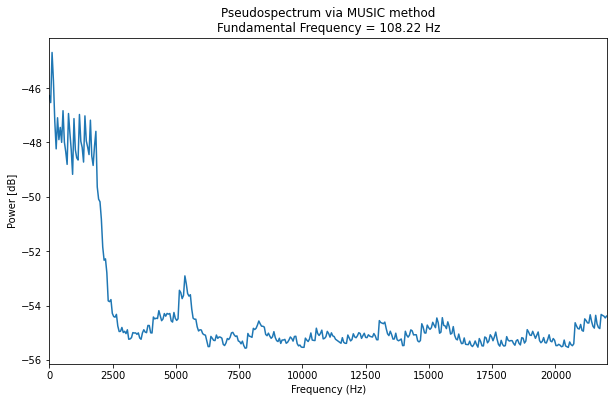

In [8]:
# 波形表示
fig = plt.figure(figsize=(10, 6))
n_samples = len(data)
time = np.arange(n_samples) / fs
plt.plot(time, data)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Waveform (/a/)")
plt.show()

# MUSIC法による疑似スペクトルの計算結果
fig = plt.figure(figsize=(10, 6))
plt.plot(freq_axis, 20 * np.log10(music_pseudo_spec))
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power [dB]")
plt.title(
    f"Pseudospectrum via MUSIC method\nFundamental Frequency = {fo:.2f} Hz")
plt.show()